**Deep Learning Image Generation**  
This assignment was completed as part of my master's in AI at NUIG.<br>
The project uses neural networks to generate image data.<br>
More specifcally, Images of handwriting are generated using an AE, a VAE and a GAN.<br>

In [ ]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers, Sequential, Model
from keras.optimizers import adam_v2
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image_dataset_from_directory
import time
import shutil

In [ ]:
# gotta do this mental stuff to load the data quickly from google drive to colab
# this cell takes a good 8 min to run
# this cell should run no matter what google account you are using
!pip install --upgrade --no-cache-dir gdown
if not os.path.exists("/content/data"):
  os.mkdir("/content/data")
! gdown --id 1VicA96g519nUuoTr1sImUO0561B1cCLJ
!apt install file
!apt-get install p7zip-full
!7z x word_50k.zip -o/content/data -y
! rm word_50k.zip

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14774 sha256=af3a4a39b19e3f256e7aa6733807636ba78deb88ef4ea51730424e339b5baaf9
  Stored in directory: /tmp/pip-ephem-wheel-cache-jzcwxir2/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.2.2
    Uninstalling gdown-4.2.2:
      Successfully uninstalled gdown-4.2.2
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1VicA96g519nUuoTr1sImUO0561B1cCLJ
To: /content/word_50k.zip
100% 511M/511M [00:04<00:00, 128MB/s]
Reading package lists... Done
Building dependency tre

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


**Section 1: Images**

The data used for this assignment is taken from the IAM handwriting database. The database contains images handwriting at several different levels (e.g. images of entire pages of handwriting, images of sentences of handwriting). I downloaded over 100,000 images of isolated handwrittent words. I randomly chose 50,000 of these images for use in this assignment.   
The data can be downloaded at the following link:  https://fki.tic.heia-fr.ch/databases/iam-handwriting-database  

An instance where generating new handwritien words could be useful would be to 
genrate new training data for a handwriting recognition neural network. An image from the training set could be embedded in the latent space using the variational autoencoder. Then you could sample points around that embedding to get different instances of the same word, so you could generate new image, label pairs for training.


In [ ]:
# The images all had diffierent shapes.
# I chose to resize all images to 96x192. This height and width is close
# to the mean height and width of the data. Also this shape allows the 
# image to be downsampled easier (e.g. 96 can be divided by 2 five times and still be a whole number).
IMG_HEIGHT = 96
IMG_WIDTH = 192
BATCH_SIZE = 64
Z_DIM = 150
ds = image_dataset_from_directory(
    directory="/content/data",
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    batch_size=BATCH_SIZE,
    color_mode="grayscale"
)
ds = ds.cache()
ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# normalize images to range [-1, 1]
ds = ds.map(lambda x, y: ((x / 127.5) - 1, y))
ds = ds.map(lambda x, y: (x, x))

Found 50000 files belonging to 1 classes.


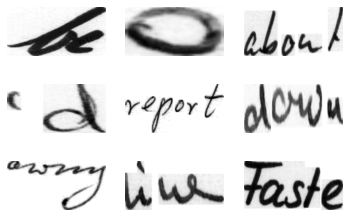

In [ ]:
# print 9 images
r = c = 3
images, _ = next(iter(ds))
fig, axs = plt.subplots(r, c)
for i in range(r):
    for j in range(c):
        image = np.squeeze(images[i*r+j])
        axs[i, j].imshow(image, cmap='gray')
        axs[i, j].axis('off')

As you can see, the resising does distort some of the very short or very long words. Also some images in the dataset are just smudges or marks of punctuation, which is not very useful when we're trying to generate handwriting.

In [ ]:
def sample_images(G, filepath="handwriting_generated.png", show_plot=False):
    # save generated images
    r, c = 5, 5
    z = np.random.normal(0, 1, (r * c, Z_DIM))
    x_fake = G.predict(z)

    fig, axs = plt.subplots(r, c)
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(x_fake[i*r+j].reshape((IMG_HEIGHT, IMG_WIDTH)), cmap='gray')
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.savefig(filepath)
    if show_plot == False:
      plt.close()

**Section 2: Networks**

**Autoencoder**

In [ ]:
def make_generator():
    # Dense layer followed by 5 upsampling layers (transposed convolution)
    inputs = layers.Input(shape=(Z_DIM, ))
    x = layers.Dense(3 * 6 * 128, use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Reshape((3, 6, 128))(x)

    x = layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # upsample using transposed convolution with stride=2
    x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding="same", use_bias=False)(x)

    # attach last conv layer to avoid unwanted artifacts caused by ConvTranspose (e.g. checkerboard)
    x = layers.Conv2D(1, (5, 5), strides=(1, 1), padding="same", use_bias=False, activation="tanh")(x)

    G = Model(inputs, x, name="generator")
    return G

In [ ]:
def make_encoder():
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))

    # downsample with 5 convolution layers with stride=2
    x = layers.Conv2D(32, (5, 5), strides=(2, 2), padding="same")(inputs)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same")(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same")(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(256, (5, 5), strides=(2, 2), padding="same")(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(256, (5, 5), strides=(2, 2), padding="same")(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(128, (5, 5), strides=(1, 1), padding="same")(x)
    x = layers.LeakyReLU()(x)

    x = layers.Flatten()(x)
    # note sigmoid activation. Latent space will be in range [0, 1]
    x = layers.Dense(Z_DIM, activation="sigmoid")(x)

    E = Model(inputs, x)
    return E

In [ ]:
# define and compile autoencoder
AE_encoder = make_encoder()
AE_decoder = make_generator()

AE_input = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
AE = Model(AE_input, AE_decoder(AE_encoder(AE_input)))
AE.compile(loss="mse", optimizer=adam_v2.Adam(0.0003, 0.9))


# train autoencoder
hist = AE.fit(
    ds,
    epochs=50,
)

Epoch 1/50
782/782 [==============================] - 354s 445ms/step - loss: 0.0912
Epoch 2/50
782/782 [==============================] - 344s 440ms/step - loss: 0.0491
Epoch 3/50
782/782 [==============================] - 344s 440ms/step - loss: 0.0422
Epoch 4/50
782/782 [==============================] - 344s 440ms/step - loss: 0.0390
Epoch 5/50
782/782 [==============================] - 344s 440ms/step - loss: 0.0369
Epoch 6/50
782/782 [==============================] - 345s 441ms/step - loss: 0.0355
Epoch 7/50
782/782 [==============================] - 346s 442ms/step - loss: 0.0341
Epoch 8/50
782/782 [==============================] - 345s 442ms/step - loss: 0.0332
Epoch 9/50
782/782 [==============================] - 345s 442ms/step - loss: 0.0322
Epoch 10/50
782/782 [==============================] - 344s 440ms/step - loss: 0.0313
Epoch 11/50
782/782 [==============================] - 344s 440ms/step - loss: 0.0307
Epoch 12/50
782/782 [==============================] - 345s 441

In [ ]:
# save autoencoder
AE.save(
    "/content/drive/MyDrive/Colab Notebooks/deep_learning/AE_l64_30ep.tf",
    overwrite=True,
    include_optimizer=True,
)

**Variational Autoencoder**

In [ ]:
class Sampling(layers.Layer):
    # define sampling layer to sample from latent space
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = K.random_normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
# the encoder for the VAE has similar architecture to the encoder for the AE
vae_inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
x = layers.Conv2D(32, (5, 5), strides=(2, 2), padding="same")(vae_inputs)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same")(vae_inputs)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same")(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same")(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256, (5, 5), strides=(2, 2), padding="same")(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(32, (5, 5), strides=(1, 1), padding="same")(x)
x = layers.LeakyReLU()(x)


x = layers.Flatten()(x)

E = Model(vae_inputs, x)


z_mean = layers.Dense(Z_DIM)(x)
z_log_var = layers.Dense(Z_DIM)(x)
z = Sampling()((z_mean, z_log_var))

E = Model(vae_inputs, z, name="variational_encoder")

In [ ]:
# define and train VAE
vae_encoder = E
vae_decoder = make_generator()

outputs = vae_decoder(vae_encoder(vae_inputs))
vae = Model(vae_inputs, outputs)

# loss = MSE + KL
recon_loss = tf.keras.losses.mse(vae_inputs, outputs)
recon_loss = np.prod(IMG_HEIGHT * IMG_WIDTH) * K.mean(recon_loss)
kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)

# add loss to model
vae.add_loss(kl_loss)
vae.add_metric(kl_loss, name="kl_loss", aggregation="mean")
vae.add_loss(recon_loss)
vae.add_metric(recon_loss, name="mse_loss", aggregation="mean")

vae.compile(optimizer=adam_v2.Adam(0.0003))

vae.fit(ds, 
        epochs=20,
        verbose=1)

In [ ]:
# save VAE
vae.save("/content/drive/MyDrive/Colab Notebooks/deep_learning/models/VAE_ep20.tf")

In [ ]:
vae.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_5 (Dense)             (None, 2304)              230400    
                                                                 
 batch_normalization (BatchN  (None, 2304)             9216      
 ormalization)                                                   
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 2304)              0         
                                                                 
 reshape (Reshape)           (None, 3, 6, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 3, 6, 256)        819200    
 nspose)                                                 

**GAN**

My GAN is based on the network in the DCGAN tutorial on the tensorflow website: https://www.tensorflow.org/tutorials/generative/dcgan  
I did change the architecture of the network somewhat (adding more layers, more filters per layer etc.)  
The training loop for the GAN is also based on this tutorial.  

In [ ]:
def make_discriminator():
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    # downsampling with strided convolution
    x = layers.Conv2D(32, (5, 5), strides=(2, 2), padding="same")(inputs)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same")(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same")(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(256, (5, 5), strides=(2, 2), padding="same")(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(256, (5, 5), strides=(2, 2), padding="same")(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (5, 5), strides=(1, 1), padding="same")(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1, activation="sigmoid")(x)

    D = Model(inputs, x)
    return D

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def D_loss_function(real_output, fake_output):
    # loss function for discriminator
    # BCE(D(real_images), real_labels) + BCE(D(fake_images), fake_labels)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def G_loss_function(fake_output):
    # loss function for generator
    # BCE(D(G(z)), real_labels)
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# use Adam optimizer for generator and discriminator
G_optimizer = tf.keras.optimizers.Adam(1e-4)
D_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
D = make_discriminator()
G = make_generator()

In [ ]:
D.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 192, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 48, 96, 32)        832       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 48, 96, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 48, 64)        51264     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 24, 48, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 24, 128)       204928    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 12, 24, 128)       0     

In [ ]:
G.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150)]             0         
                                                                 
 dense_1 (Dense)             (None, 2304)              345600    
                                                                 
 batch_normalization (BatchN  (None, 2304)             9216      
 ormalization)                                                   
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 2304)              0         
                                                                 
 reshape (Reshape)           (None, 3, 6, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 3, 6, 256)        819200    
 nspose)                                                 

In [ ]:
@tf.function
def train_step(real_images):
    # perform single training step for GAN with pytorch-style training loop
    z = np.random.normal(0, 1, (BATCH_SIZE, Z_DIM))
    # keep track of gradients for generator and discriminator separately
    with tf.GradientTape() as G_tape, tf.GradientTape() as D_tape: 
        fake_images = G(z, training=True)
    
        real_d_out = D(real_images, training=True)
        fake_d_out = D(fake_images, training=True)
    
        # calculate loss for generator and decoder
        G_loss = G_loss_function(fake_d_out)
        D_loss = D_loss_function(real_d_out, fake_d_out)
    
    
    # calculate gradients from loss
    gradients_of_G = G_tape.gradient(G_loss, G.trainable_variables)
    gradients_of_D = D_tape.gradient(D_loss, D.trainable_variables)
  
    # perform optimization step
    G_optimizer.apply_gradients(zip(gradients_of_G, G.trainable_variables))
    D_optimizer.apply_gradients(zip(gradients_of_D, D.trainable_variables))
    return G_loss, D_loss

In [ ]:
n_steps = len(ds)
sample_interval = 1
save_interval = 3

# perform training for generator and discriminator

def train(dataset, epochs):
  for epoch in range(epochs):
    print()
    print(f"epoch: {epoch}")
    for step, (real_images, _) in enumerate(dataset):
      G_loss, D_loss = train_step(real_images)
      if step % 50 == 0:
        print(f"step {step:>4}/{n_steps} G loss: {G_loss:.8f}   D loss: {D_loss:.8f}")
    if epoch % sample_interval == 0:
      print("sampling images")
      sample_filepath = f"/content/drive/MyDrive/Colab Notebooks/deep_learning/samples/GAN2_samples_step{step + len(ds)*epoch}.png"
      sample_images(G, sample_filepath)
    if epoch % save_interval == 0:
      print(f"saving model")
      G.save(f"/content/drive/MyDrive/Colab Notebooks/deep_learning/models/GAN4_gen_ep{epoch}.tf")
      D.save(f"/content/drive/MyDrive/Colab Notebooks/deep_learning/models/GAN4_disc_ep{epoch}.tf")

In [ ]:
train(ds, 50)


epoch: 0
step    0/782 G loss: 2.66126895   D loss: 0.56945342
step   50/782 G loss: 2.90485382   D loss: 0.56241477
step  100/782 G loss: 2.84074616   D loss: 0.38352156
step  150/782 G loss: 2.80734420   D loss: 0.49976385
step  200/782 G loss: 2.90075397   D loss: 0.58013833
step  250/782 G loss: 2.74868441   D loss: 0.50902283
step  300/782 G loss: 2.44626951   D loss: 0.51154459
step  350/782 G loss: 2.37160635   D loss: 0.46920174
step  400/782 G loss: 3.09676552   D loss: 0.55480134
step  450/782 G loss: 3.55661559   D loss: 0.30160737
step  500/782 G loss: 2.68815470   D loss: 0.54583824
step  550/782 G loss: 2.19162464   D loss: 0.56183583
step  600/782 G loss: 2.66093731   D loss: 0.63751256
step  650/782 G loss: 2.86025643   D loss: 0.51742208
step  700/782 G loss: 2.74674273   D loss: 0.35415679
step  750/782 G loss: 3.13206077   D loss: 0.64823204
sampling images
saving model
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/deep_learning/models/GA

In [ ]:
G.save(f"/content/drive/MyDrive/Colab Notebooks/deep_learning/models/GAN2_ep_10plus.tf")

**Part 3: Evaluation**

In [ ]:
def plot_generated_images(generator, dist_option="normal", z_dim=Z_DIM):
  # plot 3x3 grid of generated images
  r = c = 3
  if dist_option == "normal":
    z = np.random.normal(0, 1, (r*c, z_dim))
  elif dist_option == "uniform":
    z = np.random.uniform(0, 1, (r*c, z_dim))

  generated_images = decoder(z)
  fig, axs = plt.subplots(r, c)
  for i in range(r):
      for j in range(c):
          image = np.squeeze(generated_images[i*r+j])
          axs[i, j].imshow(image, cmap='gray')
          axs[i, j].axis('off')

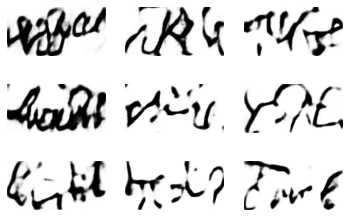

In [ ]:
# load trained AE and plot generated images
AE = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/deep_learning/models/AE_l64_30ep.tf")
decoder = AE.layers[-1]
plot_generated_images(decoder, dist_option = "uniform")

I trained the autoencoder 30 epochs each. The loss did not improve much beyond 35 epochs. The loss plateaud at around 0.02 - 0.03.   
The generated images look good. I am quite pleased with the results. It is unlikely that the network will generate an image of a handwritten english word. However, the generated images look like handwriting. In some images, you can make out certain letters. The image in row 2 column 1 almost looks like a real word. To me the word looks something like "Brouht". The image in row 1 column 1 looks like the loopy cursive style that most of the handwritten images in the training data look like.

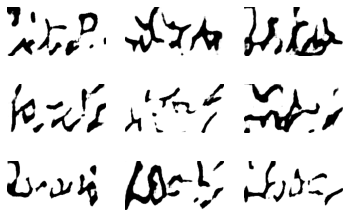

In [ ]:
# load VAE and plot generated images
vae_decoder = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/deep_learning/models/VAE_decoder_ep30.tf")
plot_generated_images(vae_decoder, dist_option="normal")

I trained the VAE for around 35 epochs. For the variational autoencoder, the loss plateaud at around 500. However, you can't compare this to the loss for the AE because they both use different loss function.  
The generated images look quite similar to those generated by the autoencoder. In the image in row 3 column 2 you can clearly make out the letters "L" and "O".

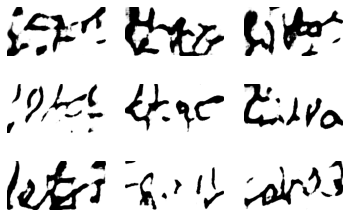

In [ ]:
# load GAN and plot generated images
GAN_generator = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/deep_learning/models/GAN4_gen_ep80.tf")
plot_generated_images(GAN_generator, dist_option="normal", z_dim=100)

I trained the GAN for over 80 epochs. It was difficult to tell if the GAN needed to be trained more.  
I think the GAN does the best job at generating images. The image in row 3 column 1 looks like someone wrote "lets's". While still not perfect, I think the results are quite impressive.  
Its hard to tell but its possible that the GAN is suffering from mode collapse. All of column 1 sort of looks like the word "let's". Many of the images have an "l" or "t" shape at the start.

Overall, I am very happy with the performance of the generators. I was surprised that the quality of the results did not vary that much across the 3 different networks. Then again, it is not easy to tell which network is doing the better job sometimes. The task of generating perfect handwriting of english words is a very difficult given the variation in the dataset. The generated images clearly capture the style of the handwriting. I did not do too much hyperparameter tuning because the networks (especially the GAN) took quite a long time to train.